<a href="https://colab.research.google.com/github/lblogan14/Python_Deep_Learning/blob/master/ch7_rnn_lang_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recurrent Neural Networks
RNNs help deal with sequences of variable length by defining a recurrence relation over these sequences. 

An RNN is defined as a recurrence relation:
$$s_t=f(s_{t-1},x_t)$$
where $f$ is a differentiable function, $s$ is a vector of values called internal network state (at step $t$), and $x_t$ is the network input at step $t$. $s_t$ is a function of both the current input as well as the previous state $s_{t-1}$. The recurrence relation defines how the state evolves step by step over the sequence via a feedback loop over previous states:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch7/rnn.PNG?raw=true)

RNN has three sets of parameters (or weights):
* $U$ transforms the input $x_t$ to the state $s_t$
* $W$ transforms the previous state $s_{t-1}$ to the output $s_t$
* $V$ maps the newly computed internal state $s_t$ to the output $y_t$

The internal state and the network output are defined as:
$$s_t=f(s_{t-1}*W+x_t*U)$$
$$y_t=s_t*V$$
where $f$ is the non-linear activation function.

In a word-level language model, the input $x$ is a sequence of words encoded in input vectors $(x_1...x_t...)$. The state $s$ will be a sequence of state vectors $(s_1...s_t...)$. The output $y$ will be a sequence of probability vectors $(y_1...y_t...)$ of the next words in sequence.

In a RNN, each state is dependent on all previous computations via this
recurrence relation.

A **stacked RNN** is form if multiple RNNs are stacked, as shown below. The cell state $s_t^l$ of a RNN cell at level $l$ at time $t$ will take the output $y_t^{l-1}$ of the RNN cell from level $l-1$ and previous cell state $s_{t-1}^l$ of the cell at the same level $l$ as the input:
$$s_t^l = f(s_{t-1}^l, y_t^{l-1})$$

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch7/stacked_rnn.PNG?raw=true)

The following are the possible applications of RNN:
* **One-to-one**: Non-sequential processing. Example: image classification
* **One-to-many**: This processing generates a sequence based on a single input, for example, caption generation from an image
* **Many-to-one**: This processing outputs a single result based on a sequence, for example, sentiment classification from text.
* **Many-to-many indirect**: A sequence is encoded into a state vector, after which this state vector is decoded into a new sequence, for example, language translation
* **Many-to-many direct**: This outputs a result for each intput step, for example, frame phoneme labeling in speech recognition.

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch7/rnn_combination.PNG?raw=true)

##RNN Implementation
Use RNN to train with a toy example, counting ones in q sequence, which is a "many-to-one" relationship. The RNN is shown below:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch7/basic_rnn.PNG?raw=true)

The network will have only two parameters: an input weight $U$ and a recurrence weight $W$. The output weight $V$ is set to 1 so as to read out the last state as the output $y$.

In [0]:
import numpy as np

In [0]:
# The first dimension represents the mini-batch
x = np.array([[0,0,0,0,1,0,1,0,1,0]])
y = np.array([3])

Define the recurrence realtion:

In [0]:
def step(s, x, U, W):
    return x * U + s * W

All the inputs are scalar values. If U=1, then wheneve input is received, its full value is obtained. If W=1, then the accumulated value would never decay.

###Backpropagation through time
The main difference between regular backpropagation and backpropagation through time is that the recurrent network is unfolded through time for a certain number of time steps as shown before. One hidden layer of that network represents one step through time. THe only differences are that each layer has multiple inputs: the previous state $s_{t-1}$ and the current input $x_t$. The parameters $U$ and $W$ are shared between all hidden layers.

The forward pass unwraps the RNN along the sequence and builds a stack of states for each step. The following is an implementation of the forward pass, which returns the activation $s$ for each recurrent step and each sample in the batch:

In [0]:
def forward(x, U, W):
    # Number of samples in the mini-batch
    number_of_samples = len(x)

    # Length of each sample
    sequence_length = len(x[0])

    # Initialize the state activation for each sample along the sequence
    s = np.zeros((number_of_samples, sequence_length + 1))

    # Update the states over the sequence
    for t in range(0, sequence_length):
        s[:, t+1] = step(s[:,t], x[:,t], U, W) # step function

    return s

Since the unfolded RNN is equivalent to a regular feedforward network, use chain rule in backpropagation.

Because the weights $W$ and $U$ are shared across the layers, the error derivatives are accumulated for each recurrent step and then the weightes are update in the end with the accumulated value.

The recurrence relation to propagate the gradient through the network can be written as
$$\frac{\partial J}{\partial s_{t-1}}=\frac{\partial J}{\partial s_t}\frac{\partial s_t}{\partial s_{t-1}}=\frac{\partial J}{\partial s_t}W$$
where $J$ is the loss function.

The gradients of the parameters are accumulated as follows:
$$\frac{\partial J}{\partial U}=\sum_{t=0}^{n}\frac{\partial J}{\partial s_{t}}x_t$$
$$\frac{\partial J}{\partial W}=\sum_{t=0}^{n}\frac{\partial J}{\partial s_{t}}s_{t-1}$$

The following is an implementation of the backward pass:

1. Accumulate the gradients $U$ and $W$ in `gU` and `gW`, respectively.

In [0]:
def backward(x, s, y, W):
    sequence_length = len(x[0])

    # The network output is just the last activation of sequence
    s_t = s[:, -1]

    # Compute the gradient of the output w.r.t. MSE cost function at final state
    gS = 2 * (s_t - y)

    # Set the gradient accumulations to 0
    gU, gW = 0, 0

    # Accumulate gradients backwards
    for k in range(sequence_length, 0, -1):
        # compute the parameter gradients and accumulate the results
        gU += np.sum(gS * x[:, k-1])
        gW += np.sum(gS * s[:, k-1])

        # compute the gradient at the output of the previous layer
        gS = gS * W

    return gU, gW

2. Use gradient descent to optimize the network with MSE

In [0]:
def train(x, y, epochs, learning_rate = 0.0005):
    '''Train the network'''

    # Set initial parameters
    weights = (-2, 0) # (U, W)

    # Accumulate the losses and their respective weights
    losses = list()
    weights_u = list()
    weights_w = list()

    # Perform iterative gradient descent
    for i in range(epochs):
        # Perform forward and backward pass to get the gradients
        s = forward(x, weights[0], weights[1])

        # Compute the loss
        loss = (y[0] - s[-1, -1])**2

        # Store the loss and weights values for later display
        losses.append(loss)

        weights_u.append(weights[0])
        weights_w.append(weights[1])

        gradients = backward(x, s, y, weights[1])

        # Update each parameter `p` by p = p - (gradient * learning_rate)
        # `gp` is the gradient of parameter `p`
        weights = tuple((p - gp*learning_rate) for p, gp in zip(weights, gradients))

    print(weights)

    return np.array(losses), np.array(weights_u), np.array(weights_w)

3. Implement the `plot_training` function to display the weights and the loss:

In [0]:
def plot_training(losses, weights_u, weights_w):
    import matplotlib.pyplot as plt

    # remove nan and inf values
    losses = losses[~np.isnan(losses)][:-1]
    weights_u = weights_u[~np.isnan(weights_u)][:-1]
    weights_w = weights_w[~np.isnan(weights_w)][:-1]

    # plot the weights U and W
    fig, ax1 = plt.subplots(figsize=(5, 3.4))

    ax1.set_ylim(-3, 2)
    ax1.set_xlabel('epochs')
    ax1.plot(weights_w, label='W', color='red', linestyle='--')
    ax1.plot(weights_u, label='U', color='blue', linestyle=':')
    ax1.legend(loc='upper left')

    # instantiate a second axis that shares the same x-axis
    # plot the loss on the second axis
    ax2 = ax1.twinx()

    # uncomment to plot exploding gradients
    ax2.set_ylim(-3, 200)
    ax2.plot(losses, label='Loss', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')

    fig.tight_layout()

    plt.show()

4. Run...

(-2.088692479228279, -0.7529413189879612)


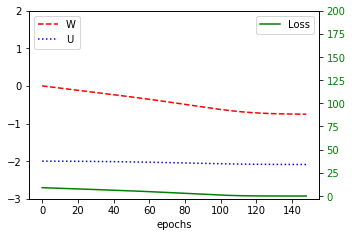

In [0]:
losses, weights_u, weights_w = train(x, y, epochs=150)
plot_training(losses, weights_u, weights_w)

###Vanishing and exploding gradients
The preceding code has an issue. Try with a longer sequence:

In [0]:
x = np.array([[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]])
y = np.array([12])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


(nan, nan)


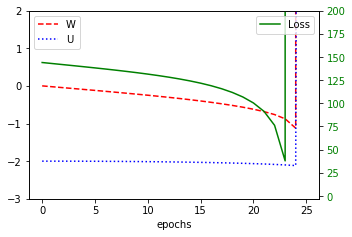

In [0]:
losses, weights_u, weights_w = train(x, y, epochs=150)
plot_training(losses, weights_u, weights_w)

The reason for these warnings is that the final parameters $U$ and $W$ end up as **Not a Number (NaN)**, as shown in the graph.

The weights slowly move toward the optimum and the loss decreases until it overshoots at epoch 23. What happens is that the cost surface trained on is highly unstable. This is known as exploding gradients.

There is also the vanishing gradient problem. The gradient decays exponentially over the number of steps to a point where it becomes extremely smaller in the earlier states. This problem is harder to detect because the training will still work and the network will produce valid outputs (unlike with exploding gradients). It just won't be able to learn long-term dependencies.

* Depending on the sequence's length, an unfolded RNN can be much deeper compared to a regular network.
* The weights W are shared across all steps, which means that the recurrence relation that propagates the gradient backward through time forms a geometric sequence:
$$\frac{\partial s_t}{\partial s_{t-m}}=W^m$$
In this simple linear RNN, the gradient grows exponentially if $|W|>1$ (exploding gradient).

##Long Short-Term Memory
LSTMs can handle long-term dependencies due to a specially crafted memory cell. The key idea of LSTM is the cell state (in addition to the hidden RNN state), where the information can only be explicitly written in or removed so that the state stays constant if there is no outside interference.

A typical LSTM is composed of three gates: a forget gate, an input gate, and an output gate.

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch7/lstm_cell.PNG?raw=true)

* $x_t, c_t, h_t$ are the LSTM input, cell memory state, and output (or hidden state) in moment $t$. $c_t'$ is the candidate cell state. The input $x_t$ and the previous cell output $h_{t-1}$ are connected to each gate and the candidate cell vector with sets of weights $W$ and $U$, respectively.
* $c_t$ is the cell state in moment $t$.
* $f_t, i_t, o_t$ are the forget, input, and output gates of the LSTM cell.

The forget gate bases its decision on the output of the previous cell $h_{t-1}$ and the current input $x_t$:
$$f_t = \sigma(W_f x_t + U_f h_{t-1})$$
It applies element-wise logistic functions on each element of the previous cell's vector $c_{t-1}$. An output of 0 erases a specific $c_{t-1}$ cell block completely and an output of 1 allows the information in that cell block to pass through.

The input gate decides what new information is going to be added to the memory cell. It bases its decision on $h_{t-1}$ and $x_t$. An output of 0 means that no information is added to that cell block's memory.
$$i_t = \sigma(W_i x_t + U_i h_{t-1})$$

The candidate input to be added, $c_t'$, is based on the previous output $h_{t-1}$ and the current input $x_t$:
$$c_t' = \tanh(W_c x_t + U_c h_{t-1})$$

The forget and input gates decide the new cell state by choosing which parts of the new and the old state to include:
$$c_t = f_t * c_{t-1} \oplus i_t * c_t'$$
The output gate decides what the total cell output is going to be. It takes $h_{t-1}$ and $x_t$ as inputs and outputs 0 or 1 (via the logistic function) for each block of the cell's memory. An output of 0 means that the block doesn't output any information, while an output of 1 means that the block can pass through as a cell's output.
$$o_t = \sigma(W_o x_t + U_o h_{t-1})$$
The LSTM cell output:
$$h_t = o_t * \tanh(c_t)$$

To protect from vanishing gradients, the cell state is copied identically from step to step if the forget gate is 1 and the input gate is 0. Only the
forget gate can completely erase the cell's memory. As a result, memory can remain unchanged over a long period of time

##Gated Recurrent Units
A GRU unit does similar or better than a LSTM but with fewer parameters and operations.

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch7/gru_cell.PNG?raw=true)

The GRU cell has two gates:
* An update gate $z_t$, which is a combination of the input and forget LSTM gates. It decides what information to discard and what new information to include in its place, based on the network input $x_t$ and the previous cell hidden state $h_{t-1}$.
$$z_t = \sigma(W_z x_t + U_z h_{t-1})$$
* A reset gate $r_t$, which uses the previous cell state $h_{t-1}$ and the network input $x_t$ to decide how much of the previous state to pass through:
$$r_t = \sigma(W_r x_t + U_r h_{t-1})$$

The candidate state $h_t'$:
$$h_t'=\tanh(W x_t + U(r_t*h_{t-1})$$
The GRU output $h_t$ at time $t$:
$$h_t = (1-z_t)*h_{t-1} \oplus z_t* h_t'$$

#Language Modeling
Language modeling is the task of computing the probability of a sequence of words.

##Word-based Models
A word-based language model defines a probability distribution over sequences of words. Given a sequence of words of length $m$, it assigns a probability $P(w_1,...,w_m)$ to the full sequence of words. These probabilities can be used to
* To estimate the likelihood of different phrases in natural language processing applications.
* To compute the likelihood of a given word to follow a sequence of words.

###N-grams
The inference of the probability of a long sequence is typically infeasible. Calculating the joint probability of $P(w_1,...,w_m)$:
$$P(w_1,...,w_m)=P(w_1)P(w_2|w_1)P(w_3|w_1,w_2)...P(w_m|w_1,...,w_{m-1})$$
The n-grams is modeled the joint probabilities of combinations of $n$ sequential words.

Given a huge corpus of text, the probabilities of the last word of each n-gram, given the previous $n-1$ words:
* **1-gram**: $P(word) = \frac{count(word)}{\mbox{total number of words in corpus}}$
* **2-gram**: $P(w_i|w_{i-1})=\frac{count(w_{i-1},w_i)}{count(w_{i-1})}$
* **N-gram**: $P(w_{n+i}|w_n,...,w_{n+i-1})=\frac{count(w_n,...,w_{n+i-1},w_{n+i})}{count(w_n,...,w_{n+i-1})}$

The $i$th word is only dependent on the previous $n-1$ words.

###Neural language models
One way to overcome the curse of dimensionality is by learning a lower dimensional, distributed representation of the words. This distributed representation is created by learning an embedding function that transforms the space of words into a lower dimensional space of word embeddings, as follows:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch7/embedding.PNG?raw=true)

Words from the vocabulary with size $V$ are transformed into one-hot encoding vectors of size $V$ (each word is encoded uniquely). Then, the embedding function transforms this $V$-dimensional space into a distributed representation of size $D$.

The idea is that the embedding function learns semantic information about the words. It associates each word in the vocabulary with a continuous-valued vector representation, that is, the word embedding. Each word corresponds to a point in this embedding space, and different dimensions correspond to the grammatical or semantic properties of these
words.

####Neural probabilistic language model
Given a sequence of $n-1$ words $(w_{t-n+1},...,w_{t-1})$, the fully-connected network tries to output the probability distribution of the next word $w_t$.

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch7/neural_prob_lang_model.PNG?raw=true)

1. The embedding layer takes the one-hot representation of the word $w_i$ and
transforms it into the word's embedding vector by multiplying it with the
embedding matrix $C$. The embedding matrix $C$ is shared over the words, so all words use the same embedding function. $C$ is represented by a $V*D$ matrix, where $V$ is the size of the vocabulary and $D$ is the size of the embedding.
2. The resulting embeddings are concatenated and serve as an input to the hidden layer, which uses `tanh` activation. The output of the hidden layer is thus $z=\tanh\left(H\cdot (concat(C(w_{t-n+1}),...,C(w_{t-1})) + d)\right)$, where $H$ is the embedding-to-hidden layer weights and $d$ are the hidden biases.
3. The output is obtained with the weights $U$, bias $b$, and softmax activation, which maps the hidden layer to the word space probability distribution: $y=softmax(z*U+b)$.

This model simultaneously learns an embedding of all the words in the
vocabulary (embedding layer) and a model of the probability function for sequences of
words (network output). It is able to generalize this probability function to sequences of
words that were not seen during training.

####word2vec
The embedding vectors are represented by the input-to-hidden weights of the network.
They are $V * D$ shaped matrices, where $V$ is the size of the vocabulary and $D$ is the length of
the embedding vector (which is the same as the number of neurons in the hidden layer).

There are two approaches:
* **Continuous bag of words (CBOW)**: the neural network is trained to
predict which word fits in a sequence of words, where a single word has been
intentionally removed, shown left in the following figure. For example, given the sqeuence "The quick _____ fox
jumps", the network will predict "brown". But the network takes only a single word as input. Therefore, this sentence is transformed into multiple training (input, target) pairs.
* **Skip-gram**: Given an input word, it predicts
which words surround it, shown right in the following figure. For example, the word "brown" will predict the
words "The quick fox jumps".

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch7/word2vec.PNG?raw=true)

##Character-based Models for Generating New Text
In most cases, language modeling is performed at the word level, where the distribution is over a fixed vocabulary of $|V|$ words. The character-level language models model the distribution over sequences of characters instead of words, thus allowing to compute probabilities over a much smaller vocabulary. However, by modeling the sequence of characters instead of words, much longer sequences is modeled to capture the same information over time. These long-term dependencies can be captured with LSTM language model.

Because the full text is too long to train a network with **backpropagation through time (BPTT)**, a batched variant called truncated BPTT is used. The training data is divided into batches of fixed sequences length and the network is trained batch by batch.

###Preprocessing and Reading data

In [0]:
'''Process text file for language model training'''
from __future__ import print_function, division

import codecs
import re

In [0]:
filepath = 'war_and_peace.txt' # in
out_file = 'wap.txt' # out

In [0]:
# Regular Expression used to clean up the text
NEW_LINE_IN_PARAGRAPH_REGEX = re.compile(r'(\S)\n(\S)')
MULTIPLE_NEWLINES_REGEX = re.compile(r'(\n)(\n)+')

In [0]:
# Read text as string
with codecs.open(filepath, encoding='utf-8', mode='r') as f_input:
    book_str = f_input.read()

In [0]:
# Cleanup
book_str = NEW_LINE_IN_PARAGRAPH_REGEX.sub('\g<1> \g<2>', book_str)
book_str = MULTIPLE_NEWLINES_REGEX.sub('\n\n', book_str)

In [0]:
# Write processed text to file
with codecs.open(out_file, encoding='utf-8', mode='w') as f_output:
    f_output.write(book_str)

To feed the data into the network, the data needs to be convertedf into a numerical format. Each character will be associated with an integer.

In [0]:
from __future__ import print_function, division
import codecs

import numpy as np
from six.moves import range

In [0]:
class DataReader(object):
    """Data reader used for training language model."""

    def __init__(self, filepath, batch_length, batch_size):
        self.batch_length = batch_length
        self.batch_size = batch_size
        # Read data into string
        with codecs.open(filepath, encoding='utf-8', mode='r') as f:
            self.data_str = f.read()
        self.data_length = len(self.data_str)
        print('data_length: ', self.data_length)
        # Create a list of characters, indices are class indices for softmax
        char_set = set()
        for ch in self.data_str:
            char_set.add(ch)
        self.char_list = sorted(list(char_set))
        print('char_list: ', len(self.char_list), self.char_list)
        # Create reverse mapping to look up the index based on the character
        self.char_dict = {val: idx for idx, val in enumerate(self.char_list)}
        print('char_dict: ', self.char_dict)
        # Initalise random start indices
        self.reset_indices()

    def reset_indices(self):
        self.start_idxs = np.random.random_integers(
            0, self.data_length, self.batch_size)

    def get_sample(self, start_idx, length):
        # Get a sample and wrap around the data string
        return [self.char_dict[self.data_str[i % self.data_length]]
                for i in range(start_idx, start_idx + length)]

    def get_input_target_sample(self, start_idx):
        sample = self.get_sample(start_idx, self.batch_length + 1)
        inpt = sample[0:self.batch_length]
        trgt = sample[1:self.batch_length + 1]
        return inpt, trgt

    def get_batch(self, start_idxs):
        input_batch = np.zeros((self.batch_size, self.batch_length),
                               dtype=np.int32)
        target_batch = np.zeros((self.batch_size, self.batch_length),
                                dtype=np.int32)
        for i, start_idx in enumerate(start_idxs):
            inpt, trgt = self.get_input_target_sample(start_idx)
            input_batch[i, :] = inpt
            target_batch[i, :] = trgt
        return input_batch, target_batch

    def __iter__(self):
        while True:
            input_batch, target_batch = self.get_batch(self.start_idxs)
            self.start_idxs = (
                                      self.start_idxs + self.batch_length) % self.data_length
            yield input_batch, target_batch

In [0]:
filepath = './wap.txt'
batch_length = 10
batch_size = 2
reader = DataReader(filepath, batch_length, batch_size)
s = 'As in the question of astronomy then, so in the question of history now,'
print([reader.char_dict[c] for c in s])

###LSTM Network
![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch7/lstm_char_lang_model.PNG?raw=true)

In [0]:
# -*- coding: utf-8 -*-
from __future__ import print_function, division

import time

import data_reader
import numpy as np
import tensorflow as tf

In [0]:
class Model(object):
    """RNN language model."""

    def __init__(self, batch_size, sequence_length, lstm_sizes, dropout,
                 labels, save_path):
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.lstm_sizes = lstm_sizes
        self.labels = labels
        self.label_map = {val: idx for idx, val in enumerate(labels)}
        self.number_of_characters = len(labels)
        self.save_path = save_path
        self.dropout = dropout

    def init_graph(self):
        # Variable sequence length
        self.inputs = tf.placeholder(
            tf.int32, [self.batch_size, self.sequence_length])
        self.targets = tf.placeholder(
            tf.int32, [self.batch_size, self.sequence_length])
        self.init_architecture()
        self.saver = tf.train.Saver(tf.trainable_variables())

    def init_architecture(self):
        # Define a multilayer LSTM cell
        self.one_hot_inputs = tf.one_hot(
            self.inputs, depth=self.number_of_characters)
        cell_list = [tf.nn.rnn_cell.LSTMCell(lstm_size) for lstm_size in self.lstm_sizes]
        self.multi_cell_lstm = tf.nn.rnn_cell.MultiRNNCell(cell_list)
        # Initial state of the LSTM memory.
        # Keep state in graph memory to use between batches
        self.initial_state = self.multi_cell_lstm.zero_state(
            self.batch_size, tf.float32)
        # Convert to variables so that the state can be stored between batches
        # Note that LSTM states is a tuple of tensors, this structure has to be
        # re-created in order to use as LSTM state.
        self.state_variables = tf.contrib.framework.nest.pack_sequence_as(
            self.initial_state,
            [tf.Variable(var, trainable=False)
             for var in tf.contrib.framework.nest.flatten(self.initial_state)])
        # Define the rnn through time
        lstm_output, final_state = tf.nn.dynamic_rnn(
            cell=self.multi_cell_lstm, inputs=self.one_hot_inputs,
            initial_state=self.state_variables)
        # Force the initial state to be set to the new state for the next batch
        # before returning the output
        store_states = [
            state_variable.assign(new_state)
            for (state_variable, new_state) in zip(
                tf.contrib.framework.nest.flatten(self.state_variables),
                tf.contrib.framework.nest.flatten(final_state))]
        with tf.control_dependencies(store_states):
            lstm_output = tf.identity(lstm_output)
        # Reshape so that we can apply the linear transformation to all outputs
        output_flat = tf.reshape(lstm_output, (-1, self.lstm_sizes[-1]))
        # Define output layer
        self.logit_weights = tf.Variable(
            tf.truncated_normal(
                (self.lstm_sizes[-1], self.number_of_characters), stddev=0.01),
            name='logit_weights')
        self.logit_bias = tf.Variable(
            tf.zeros((self.number_of_characters)), name='logit_bias')
        # Apply last layer transformation
        self.logits_flat = tf.matmul(
            output_flat, self.logit_weights) + self.logit_bias
        probabilities_flat = tf.nn.softmax(self.logits_flat)
        self.probabilities = tf.reshape(
            probabilities_flat,
            (self.batch_size, -1, self.number_of_characters))

    def init_train_op(self, optimizer):
        # Flatten the targets to be compatible with the flattened logits
        targets_flat = tf.reshape(self.targets, (-1,))
        # Get the loss over all outputs
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=self.logits_flat, labels=targets_flat, name='x_entropy')
        self.loss = tf.reduce_mean(loss)
        trainable_variables = tf.trainable_variables()
        gradients = tf.gradients(loss, trainable_variables)
        gradients, _ = tf.clip_by_global_norm(gradients, 5)
        self.train_op = optimizer.apply_gradients(zip(gradients, trainable_variables))

    def sample(self, session, prime_string, sample_length):
        self.reset_state(session)
        # Prime state
        print('prime_string: ', prime_string)
        for character in prime_string:
            character_idx = self.label_map[character]
            out = session.run(
                self.probabilities,
                feed_dict={self.inputs: np.asarray([[character_idx]])})
        output_sample = prime_string
        print('start sampling')
        # Sample for sample_length steps
        for _ in range(sample_length):
            sample_label = np.random.choice(
                self.labels, size=(1), p=out[0, 0])[0]
            output_sample += sample_label
            sample_idx = self.label_map[sample_label]
            out = session.run(
                self.probabilities,
                feed_dict={self.inputs: np.asarray([[sample_idx]])})

        return output_sample

    def reset_state(self, session):
        for state in tf.contrib.framework.nest.flatten(self.state_variables):
            session.run(state.initializer)

    def save(self, sess):
        self.saver.save(sess, self.save_path)

    def restore(self, sess):
        self.saver.restore(sess, self.save_path)

###Training and Sampling

In [0]:
def train_and_sample(minibatch_iterations, restore):
    tf.reset_default_graph()
    batch_size = 64
    lstm_sizes = [512, 512]
    batch_len = 100
    learning_rate = 2e-3

    filepath = './wap.txt'

    data_feed = data_reader.DataReader(
        filepath, batch_len, batch_size)
    labels = data_feed.char_list
    print('labels: ', labels)

    save_path = './model.tf'
    model = Model(
        batch_size, batch_len, lstm_sizes, 0.8, labels,
        save_path)
    model.init_graph()
    optimizer = tf.train.AdamOptimizer(learning_rate)
    model.init_train_op(optimizer)

    init_op = tf.initialize_all_variables()
    with tf.Session() as sess:
        sess.run(init_op)
        if restore:
            print('Restoring model')
            model.restore(sess)
        model.reset_state(sess)
        start_time = time.time()
        for i in range(minibatch_iterations):
            input_batch, target_batch = next(iter(data_feed))
            loss, _ = sess.run(
                [model.loss, model.train_op],
                feed_dict={model.inputs: input_batch, model.targets: target_batch})
            if i % 50 == 0 and i != 0:
                print('i: ', i)
                duration = time.time() - start_time
                print('loss: {} ({} sec.)'.format(loss, duration))
                start_time = time.time()
            if i % 1000 == 0 and i != 0:
                model.save(sess)
            if i % 100 == 0 and i != 0:
                print('Reset initial state')
                model.reset_state(sess)
            if i % 1000 == 0 and i != 0:
                print('Reset minibatch feeder')
                data_feed.reset_indices()
        model.save(sess)

    print('\n sampling after {} iterations'.format(minibatch_iterations))
    tf.reset_default_graph()
    model = Model(
        1, None, lstm_sizes, 1.0, labels, save_path)
    model.init_graph()
    init_op = tf.initialize_all_variables()
    with tf.Session() as sess:
        sess.run(init_op)
        model.restore(sess)
        print('\nSample 1:')
        sample = model.sample(
            sess, prime_string=u'\n\nThis feeling was ', sample_length=500)
        print(u'sample: \n{}'.format(sample))
        print('\nSample 2:')
        sample = model.sample(
            sess, prime_string=u'She was born in the year ', sample_length=500)
        print(u'sample: \n{}'.format(sample))
        print('\nSample 3:')
        sample = model.sample(
            sess, prime_string=u'The meaning of this all is ',
            sample_length=500)
        print(u'sample: \n{}'.format(sample))
        print('\nSample 4:')
        sample = model.sample(
            sess,
            prime_string=u'In the midst of a conversation on political matters Anna Pávlovna burst out:,',
            sample_length=500)
        print(u'sample: \n{}'.format(sample))
        print('\nSample 5:')
        sample = model.sample(
            sess, prime_string=u'\n\nCHAPTER X\n\n',
            sample_length=500)
        print(u'sample: \n{}'.format(sample))
        print('\nSample 5:')
        sample = model.sample(
            sess, prime_string=u'"If only you knew,"',
            sample_length=500)
        print(u'sample: \n{}'.format(sample))

In [0]:
total_iterations = 500
print('\n\n\nTrain for {}'.format(500))
print('Total iters: {}'.format(total_iterations))
train_and_sample(500, restore=False)
for i in [500, 1000, 3000, 5000, 10000, 30000, 50000, 100000, 300000]:
    total_iterations += i
    print('\n\n\nTrain for {}'.format(i))
    print('Total iters: {}'.format(total_iterations))
    train_and_sample(i, restore=True)